# Building our models: ALS recommender + Deep Neural Network

### In this notebook we build and test our models: an ALS recommendation system for generating additional hashtags, and a deep neural network for classifying new images to solve the cold start problem. 

### If you wish to reproduce the training steps taken here, you will of course need the dataset. Unfortunately the 3,000 pictures we used exceed Git's size file storage allowances, so you will need to scrape your own images (and of course their associated hashtags). Please refer to scraping.ipynb which features a fully automated pipeline for doing this. 

In [1]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0 --ignore-installed

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from PIL import Image
import io
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from sklearn.model_selection import train_test_split
from functools import reduce
from functions import prepare_image, extract_features
import os
from tqdm import tqdm
from scipy.spatial.distance import cosine
np.random.seed(0)

### Get a list of all hashtags

In [4]:
json_file_names = os.listdir('metadata')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

# remove '.DS_', '.ipynb_checkp'
non_hashtags = ['.DS_', '.ipynb_checkp']
for non_hashtag in non_hashtags:
    try:
        hashtags.remove(non_hashtag)
    except:
        pass # If we can't remove it, it's already gone
    
hashtags

['fitness',
 'selfie',
 'travel',
 'nature',
 'babies',
 'cars',
 'food',
 'architecture',
 'animals',
 'wedding']

In [5]:
# Build a dataframe of hashtag metadata
hashtag_metadata = []
for hashtag in hashtags: 
    hashtag_metadata.append(pd.read_json(f'metadata/{hashtag}.json'))
hashtag_metadata = reduce(lambda x, y: pd.concat([x, y]), hashtag_metadata)
pd.DataFrame.reset_index(hashtag_metadata, drop=True, inplace=True)
hashtag_metadata.tail()

hashtags  \
2995  [#Wedding, #ido, #ianandwendytietheknot, #wedd...   
2996  [#wedding, #mariages, #celebrantecuritiba, #ce...   
2997  [#weddingring, #wedding, #shoes, #nancy, #sigm...   
2998  [#wedding, #standesamtgoetheallee, #retroweddi...   
2999  [#kinalik, #gelinlik, #bursad, #wedding, #dama...   

                                                  image  \
2995  https://scontent-sea1-1.cdninstagram.com/vp/29...   
2996  https://scontent-sea1-1.cdninstagram.com/vp/bb...   
2997  https://scontent-sea1-1.cdninstagram.com/vp/25...   
2998  https://scontent-sea1-1.cdninstagram.com/vp/21...   
2999  https://scontent-sea1-1.cdninstagram.com/vp/15...   

                              image_local_name  \
2995  905a1d9c-b29d-44c7-ab5c-408c0b5d91ac.jpg   
2996  6e424f02-d10e-42db-a233-9ce2724fb8a9.jpg   
2997  ae49d2bb-95f7-4d16-9ee5-1603e97e6dd8.jpg   
2998  9152a6d4-abda-4adf-87a4-7988dc4bb3ac.jpg   
2999  09aaa471-2ed6-4ead-84db-e4aa6b0ece8f.jpg   

                                     post_link search_hashtag  
2995  https://www.instagram.com/p/B0dcq0FBPQ3/        wedding  
2996  https://www.instagram.com/p/BwXbu7MgCTZ/        wedding  
2997  https://www.instagram.com/p/B0gwuc2icKv/        wedding  
2998  https://www.instagram.com/p/B0gwufzImAz/        wedding  
2999  https://www.instagram.com/p/B0gwubDhu6M/        wedding

In [6]:
# Remove non-hashtags from hashtag list. 
hashtag_metadata['hashtags'] = hashtag_metadata['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

# Create a flattened list of all hashtags
all_hashtags = [hashtag for hashtags in hashtag_metadata['hashtags'] for hashtag in hashtags]

# Coerce to a set to remove duplicate entries
# Sort to ensure reproducibility of results
all_hashtags = sorted(list(set(all_hashtags)))

# Build lookup for finding hashtag number based on hashtag name
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [7]:
hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

hashtag_id  image_id  rating
47467        3531      2999       1
47468        2321      2999       1
47469        8883      2999       1
47470       15048      2999       1
47471        1313      2999       1

# Creating our Neural Network

In [8]:
img_shape = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

### Neural networks require very specifically and consistently formatted image data. In the code cell below we build a list of dictionaries each describing one picture: the file name, the (main) hashtag, and of course the image data itself (represented using a TensorFlow "EagerTensor" type). 

In [9]:
pics = []
for i, row in tqdm(hashtag_metadata.iterrows()):
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path, where='local')
        deep_features = extract_features(img, neural_network)
        pics.append({'pic': img, 
                     'hashtag': hashtag, 
                     'name': name,
                     'deep_features': deep_features})
    except Exception as e:
        error_type = type(e).__name__
        if error_type == "NotFoundError":
            # If a file in the list isn't in 
            # storage, skip it and continue
            pass
        else:
            print(e)

3000it [03:41, 13.52it/s]


In [10]:
pics = pd.DataFrame(pics)
pics.index = pics['name']
pics.head()

deep_features  \
name                                                                                          
ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg  [0.0, 0.0, 0.04703789, 0.80316925, 0.0, 0.0, 0...   
7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg  [0.28235418, 0.73190904, 0.4228987, 1.8675488,...   
b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg  [0.0, 0.0, 0.01095562, 0.034995824, 0.0, 0.109...   
f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg  [0.045899887, 0.0, 0.18059976, 0.0, 0.08909201...   
7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg  [3.3825152, 0.109845184, 0.0, 0.8362177, 0.857...   

                                          hashtag  \
name                                                
ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg  fitness   
7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg  fitness   
b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg  fitness   
f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg  fitness   
7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg  fitness   

                                                                              name  \
name                                                                                 
ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg  ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg   
7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg  7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg   
b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg  b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg   
f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg  f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg   
7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg  7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg   

                                                                                        pic  
name                                                                                         
ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg  (((tf.Tensor(0.99215686, shape=(), dtype=float...  
7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg  (((tf.Tensor(0.23921573, shape=(), dtype=float...  
b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg  (((tf.Tensor(-0.73921573, shape=(), dtype=floa...  
f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg  (((tf.Tensor(0.6784314, shape=(), dtype=float3...  
7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg  (((tf.Tensor(0.654902, shape=(), dtype=float32...

### Checking out one of the pictures in our dataset.

In [11]:
pic = pics.iloc[0] 
type(pic['pic'])

tensorflow.python.framework.ops.EagerTensor

W1006 17:19:34.181281 4344337856 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


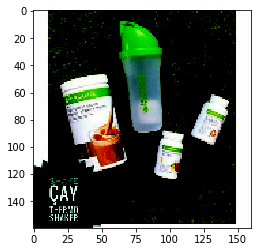

In [12]:
plt.imshow(pic['pic']);

In [13]:
pic['hashtag'], pic['deep_features'].shape, pic['pic'].shape

('fitness', (1280,), TensorShape([160, 160, 3]))

# Building our ALS Model

### In order to appreciably populate a fresh post with new hashtags, we need more than just the singular hashtag that a categorization approach such as our neural network can provide. ALS provides a solution through collaborative filtering: essentially the idea is that if a set of posts all have the same few hashtags in common and a bunch of other unique hashtags, the hashtags that are unique to those posts can probably be applied to all of them. In practice this works uncannily well and is the basis of many modern recommendation systems--remember seeing "People who bought this also bought..."? 

### In addition to supplementing our cold start solution, ALS can add new hashtags to images that already have them in much the same way that it can sell new products to users that have already bought things. So if any image has no hashtags at all or just doesn't have as many as we want it to have yet, we can add more to it either way. 

In [14]:
spark = SparkSession.builder.master('local').getOrCreate()

In [15]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

als.setSeed(0)

hashtag_spark_df = spark.createDataFrame(hashtag_rec_data)
als_model = als.fit(hashtag_spark_df)
# als_model.write().overwrite().save('als')

In [16]:
hashtag_rec_data = []
for i in hashtag_metadata.index:
    hashtag_list = hashtag_metadata.loc[i, 'hashtags']
    for hashtag in hashtag_list:
        hashtag_rec_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_rec_data = pd.DataFrame(hashtag_rec_data)
hashtag_rec_data.tail()

hashtag_id  image_id  rating
47467        3531      2999       1
47468        2321      2999       1
47469        8883      2999       1
47470       15048      2999       1
47471        1313      2999       1

In [17]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()
recs.tail()

image_id                                    recommendations
2256       517  [(14576, 1.2808759212493896), (8149, 1.2070621...
2257      2457  [(4517, 1.0268266201019287), (1533, 1.01393651...
2258      2487  [(9811, 0.8755112290382385), (8673, 0.82429075...
2259      1138  [(13727, 1.0400193929672241), (13689, 1.023955...
2260        89  [(7441, 1.0393893718719482), (8673, 1.02023041...

In [18]:
hashtag_index = list(all_hashtags)
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [19]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)
recs.index = recs['image_id']
recs = recs.join(hashtag_metadata, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [20]:
recs.drop('recommendations', axis=1, inplace=True)
image_factors = als_model.userFactors.toPandas()
image_factors.index = image_factors['id']
recs.join(image_factors);

In [21]:
# Add deep features information to recs dataframe
recs_deep = recs.join(pics, on='image_local_name', how='inner')
recs_deep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2261 entries, 1580 to 89
Data columns (total 8 columns):
recommended_hashtags    2261 non-null object
hashtags                2261 non-null object
image_local_name        2261 non-null object
search_hashtag          2261 non-null object
deep_features           2261 non-null object
hashtag                 2261 non-null object
name                    2261 non-null object
pic                     2261 non-null object
dtypes: object(8)
memory usage: 159.0+ KB


In [22]:
recs.loc[0, 'image_local_name']

'ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg'

In [23]:
len(hashtag_lookup), type(hashtag_lookup)

(15248, dict)

In [24]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

0
#A            0
#ADN          1
#AFV          2
#AMG          3
#ANGELCORONA  4

In [25]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']
hashtags_df.index = hashtags_df['id']
hashtags_df.drop('id', axis=1, inplace=True)
hashtags_df.head()

hashtag
id              
0             #A
1           #ADN
2           #AFV
3           #AMG
4   #ANGELCORONA

In [26]:
img_features = als_model.userFactors.toPandas()
hashtag_features = als_model.itemFactors.toPandas()

In [27]:
# Only use certain columns
recs_deep_clean = recs_deep[['image_local_name', 'hashtags', 'deep_features']]

img_features.index = img_features['id']
img_features.drop(['id'], axis=1)

# Add image feature into dataframe
recommender_df = recs_deep_clean.join(img_features, how='inner')
recommender_df.head()

image_local_name  \
1580  88039d35-d189-4db3-926e-a120d88a3efc.jpg   
471   fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg   
1591  1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg   
463   a78d0e30-6afa-436a-a953-633ef3f64325.jpg   
833   535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg   

                                               hashtags  \
1580  [#checkeredflag, #atv, #flagmanracing, #dirtbi...   
471   [#followme, #fashiondaily, #summer, #food, #ma...   
1591  [#bidlemanchevrolet, #suvs, #cars, #cardeals, ...   
463   [#followme, #hotguy, #instaboy, #gay, #instaga...   
833   [#arte, #interiordesign, #archilovers, #argent...   

                                          deep_features    id  \
1580  [0.05277507, 0.008059845, 0.37157044, 1.259721...  1580   
471   [0.8612797, 0.0, 0.0, 0.0, 0.47858256, 0.28118...   471   
1591  [0.0, 0.0, 0.0, 2.6671624, 0.11534053, 0.01738...  1591   
463   [0.11383952, 0.0, 1.6760653, 0.46152505, 0.062...   463   
833   [0.40182838, 0.0, 0.028864231, 0.0, 0.13101286...   833   

                                               features  
1580  [-0.7663350105285645, -0.1312631368637085, -0....  
471   [0.2623550593852997, -0.2806769907474518, -1.0...  
1591  [-0.17759329080581665, -0.05472369119524956, 0...  
463   [0.19329072535037994, -0.48493003845214844, -0...  
833   [0.034018490463495255, 0.5612558722496033, -0....

# Generating Hashtags for New Images

### Collaborative filtering methods such as ALS are extremely effective, but as previously mentioned they are limited in that they assume you have at least some information about each thing you are recommending for. This is the cold start problem.

### A conventional solution to the cold start problem might be to average the feature vectors for every single user (or in this case, image) in the dataset so far. Intuitively we would expect this to lead to recommending products or hashtags with broad and popular appeal, which is a good and safe option. 

### However, recommending hashtags for images is an unusual problem and gives us unusual opportunities. We decided to generate a deep features vector for each new image, find the 5 most similar images in our dataset based (based on cosine vector similarity), and base our hashtag recommendations off of the hashtags of those 5 most similar images. Next steps in iteratively improving this model would include cross-validating against different approaches, such as using the NN to generate a first hashtag and then proceeding with the normal collaborative filtering approach. 

In [41]:
# Function that finds k nearest neighbors by cosine similarity
def find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df):
    """Find image features (user vectors) for similar images."""
    prep_image = prepare_image(image_path, where='local')
    pics = extract_features(prep_image, neural_network)
    rdf = recommender_df.copy()
    rdf['dist'] = rdf['deep_features'].apply(lambda x: cosine(x, pics))
    rdf = rdf.sort_values(by='dist')
    return rdf.head(k)

In [42]:
def generate_hashtags(image_path):
    fnv = find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df)
    # Find the average of the 5 user features found based on cosine similarity.
    features = []
    for item in fnv.features.values:
        features.append(item)

    avg_features = np.mean(np.asarray(features), axis=0)
    
    # Add new column to the hashtag features which will be the dot product with the average image(user) features
    hashtag_features['dot_product'] = hashtag_features['features'].apply(lambda x: np.asarray(x).dot(avg_features))

    # Find the 10 hashtags with the highest feature dot products
    final_recs = hashtag_features.sort_values(by='dot_product', ascending=False).head(10)
    # Look up hashtags by their numeric IDs
    output = []
    for hashtag_id in final_recs.id.values:
        output.append(hashtags_df.iloc[hashtag_id]['hashtag'])
    return output

In [73]:
def show_results(test_image):
    img = mpimg.imread(f'test/{test_image}.jpg')
    plt.figure(figsize=(9, 9))
    plt.title(test_image, fontsize=32)        
    plt.imshow(img)
    
    recommended_hashtags = generate_hashtags(f'test/{test_image}.jpg')
    print(', '.join(recommended_hashtags))

#love, #photography, #instagood, #travel, #instagram, #photooftheday, #fashion, #beautiful, #happy, #selfie


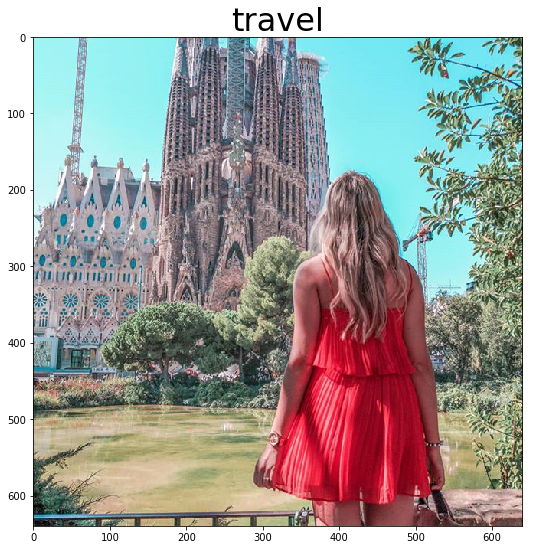

In [76]:
show_results('travel')

#food, #instafood, #yummy, #love, #wedding, #foodporn, #foodie, #foodstagram, #foodphotography, #summer


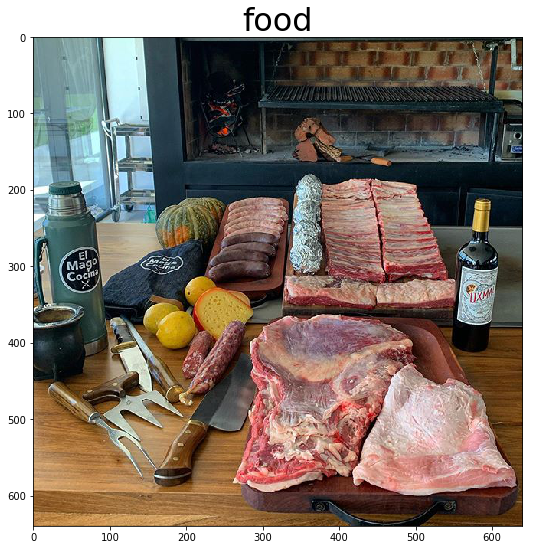

In [77]:
show_results('food')

#animals, #cute, #nature, #pets, #cat, #cats, #animal, #dog, #pet, #dogs


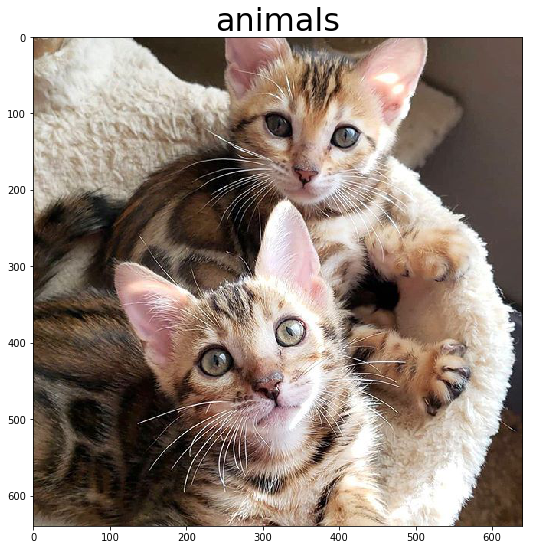

In [78]:
show_results('animals')

#selfie, #wedding, #fashion, #ootd, #style, #me, #model, #music, #likeforlikes, #like


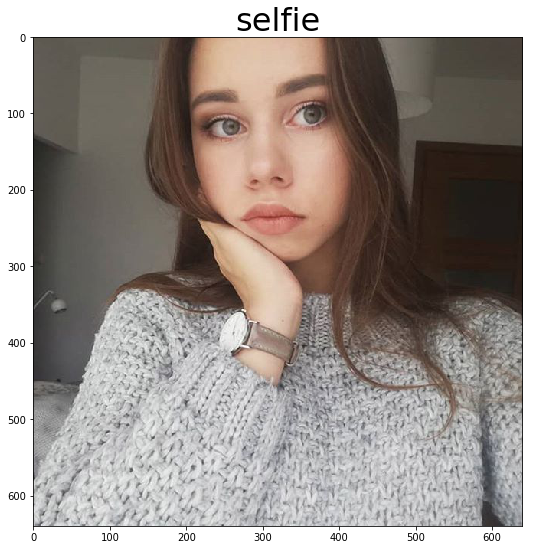

In [79]:
show_results('selfie')

#cars, #car, #s, #c, #jdm, #carlifestyle, #carporn, #carsofinstagram, #ford, #racing


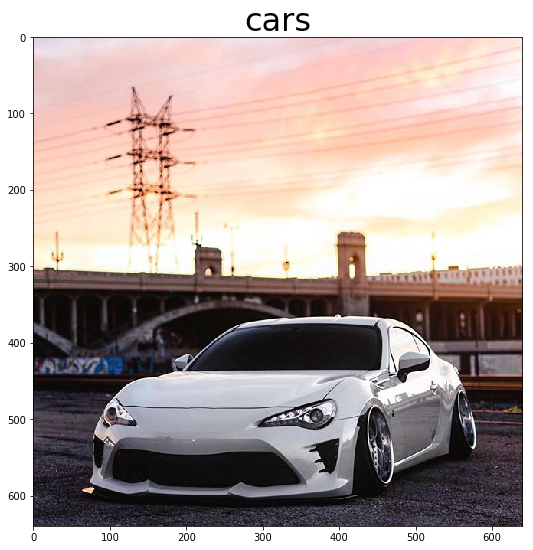

In [80]:
show_results('cars')

#fitness, #love, #selfie, #instagood, #fashion, #travel, #happy, #me, #life, #instagram


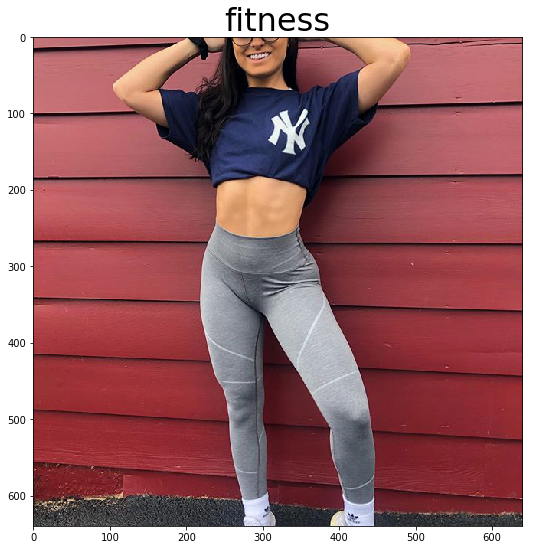

In [81]:
show_results('fitness')

#wedding, #love, #photography, #bride, #weddingday, #photographer, #photoshoot, #artist, #weddingdress, #makeup


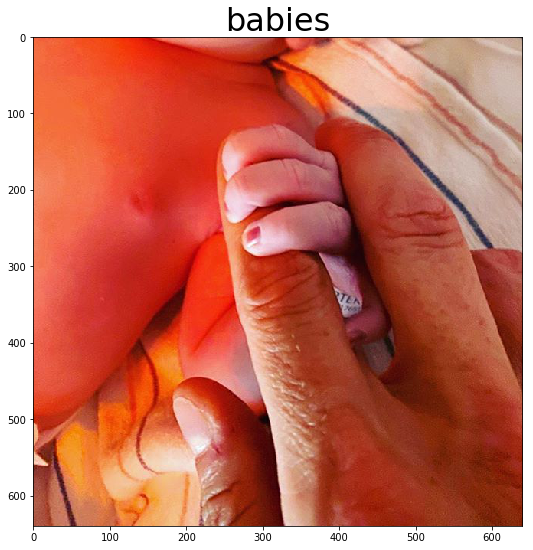

In [82]:
show_results('babies')

#love, #fashion, #instagood, #summer, #photography, #travel, #happy, #art, #like, #picoftheday


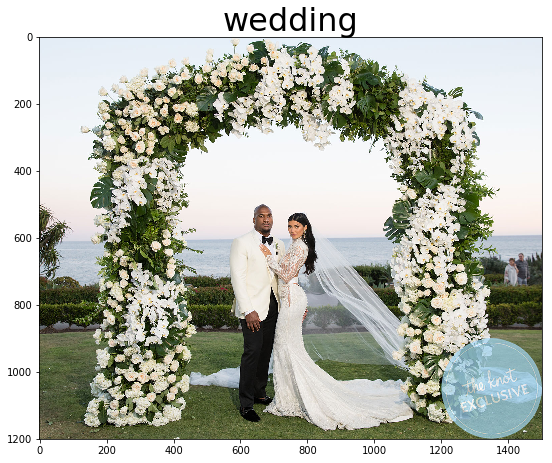

In [83]:
show_results('wedding')

#travel, #photography, #nature, #instagood, #photooftheday, #summer, #love, #instagram, #picoftheday, #beautiful


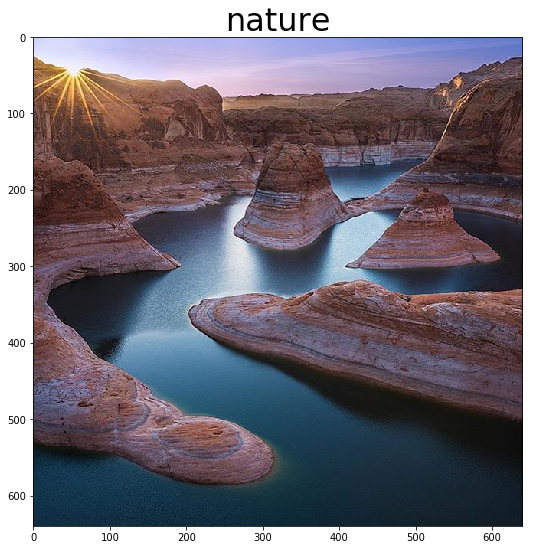

In [84]:
show_results('nature')

#travel, #photography, #nature, #love, #instagood, #fashion, #art, #photo, #beautiful, #summer


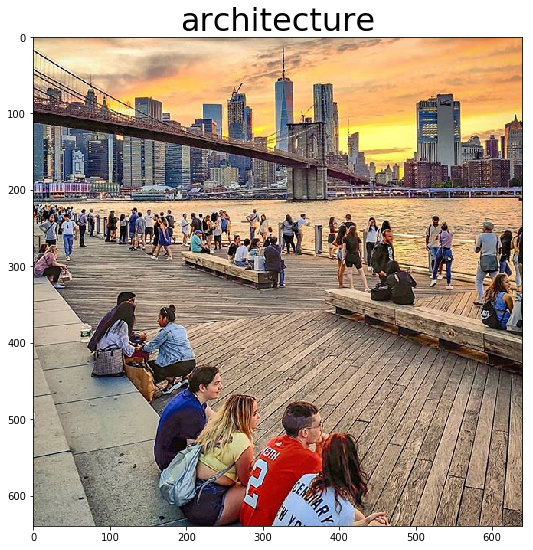

In [85]:
show_results('architecture')

### As you can see, the model's predictions are sometimes uncannily good, sometimes far more questionable. To a large extent this is simply due to the limitations of modern machine learning and the fact that some of these images are quite difficulty to classify. 

### Nevertheless, it's surely possible to do better. If this project were to be improved upon, some logical next steps would be cross validation of neural network models and of different ensemble techniques. Fine tuning pretrained nets to classify on the presented categories, for example, might significantly increase the usefulness of their deep features. Additionally, it would be interesting to see how well the ALS model would perform when the neural network gives it one free hashtag to work with instead of a deep feature vector. 

### Even so, it's clearly quite capable even in its current state, and we have intentions to integrate this model into a Flask app to further demonstrate its real world capabilities. 